In [1]:
def set_hadoop_config(credentials):
    prefix = "fs.swift.service." + credentials['name'] 
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + ".auth.url", credentials['auth_url']+'/v3/auth/tokens')
    hconf.set(prefix + ".auth.endpoint.prefix", "endpoints")
    hconf.set(prefix + ".tenant", credentials['project_id'])
    hconf.set(prefix + ".username", credentials['user_id'])
    hconf.set(prefix + ".password", credentials['password'])
    hconf.setInt(prefix + ".http.port", 8080)
    hconf.set(prefix + ".region", credentials['region'])
    hconf.setBoolean(prefix + ".public", True)

In [2]:
credentials = {
  'auth_url':'https://identity.open.softlayer.com',
  'project':'object_storage_afb98502_59e1_4eb1_a646_f3a3969f898d',
  'project_id':'0e0fc7828c5e4d2a92ec9aed289af4c6',
  'region':'dallas',
  'user_id':'6d3e88c5bf964f86b2e6bbb53d561d1f',
  'domain_id':'5c0e333aa3fd47d29a282818e646e8ed',
  'domain_name':'1141207',
  'username':'admin_b0a092623127b245412dec1a4bf9fe18b441700c',
  'password':"""kX..27t[pWEc}V[z""",
  'filename':'Train_Wreck_Data.csv',
  'container':'notebooks',
  'tenantId':'s68c-e03e15c2338850-5b7840cc6294'
}

In [3]:
credentials['name'] = 'keystone'
set_hadoop_config(credentials)

In [4]:
from __future__ import division
import numpy as np

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

sc.addPyFile("https://raw.githubusercontent.com/seahboonsiew/pyspark-csv/master/pyspark_csv.py")
import pyspark_csv as pycsv

accidents = sc.textFile("swift://" + credentials['container'] + "." + credentials['name'] + "/Train_Wreck_Data.csv")

def skip_header(idx, iterator):
    if (idx == 0):
        next(iterator)
    return iterator

accidents_header = accidents.first()


accidents_header_list = accidents_header.split(",")
accidents_body = accidents.mapPartitionsWithIndex(skip_header)

accidents_body = accidents_body.filter(lambda line : len(line.split(","))>5)

accidents_df = pycsv.csvToDataFrame(sqlContext, accidents_body, sep=",", columns=accidents_header_list)
accidents_df.cache()

DataFrame[Date: timestamp, Place: string, Street: string, Railroad: string, Description: string]

In [5]:
accidents_df.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Place: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- Railroad: string (nullable = true)
 |-- Description: string (nullable = true)



In [6]:
accidents_df.take(1)

[Row(Date=datetime.datetime(2016, 4, 30, 17, 45), Place=u'CROWLEY, LOUISIANA', Street=u'SIDNEY RICHARD ROAD', Railroad=u'Union Pacific Railroad Company', Description=u'PICKUP TRUCK STOPPED TOO CLOSE TO THE TRACKS AND WAS STRUCK BY THE ONCOMING TRAIN. #32 WARNING DEVICES: YIELD SIGN')]

In [7]:
accidents_df.count()

541

In [8]:
!pip install --user seaborn

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt

import matplotlib.patches as mpatches

import seaborn as sns
import pandas as pd

In [10]:
accidents_pd = accidents_df[['Street', 'Place', 'Railroad', 'Date', 'Description']].toPandas()

accidents_pd.columns = ['Street', 'Place', 'Railroad', 'Date', 'Description']

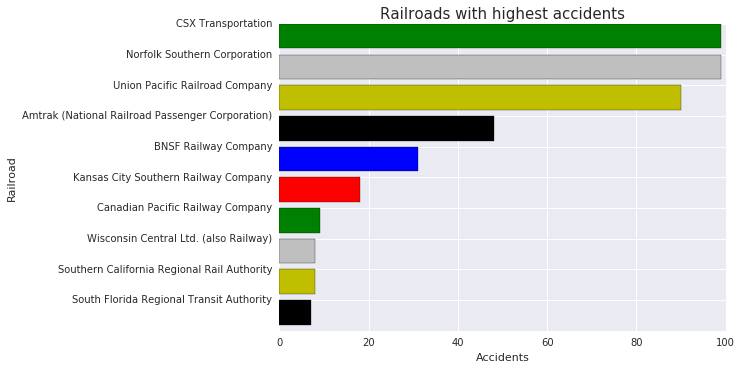

In [11]:
railroads = accidents_df.groupBy('Railroad').count().sort('count', ascending=False).toPandas()
colors = ['g','0.75','y','k','b','r']
railroads = railroads.ix[:9]
plt.barh(range(10),railroads['count'], color=colors)
plt.xlabel('Accidents')
plt.ylabel('Railroad')
plt.title('Railroads with highest accidents', size=15)
plt.yticks(range(10), railroads['Railroad'])
plt.gca().invert_yaxis()
plt.show()

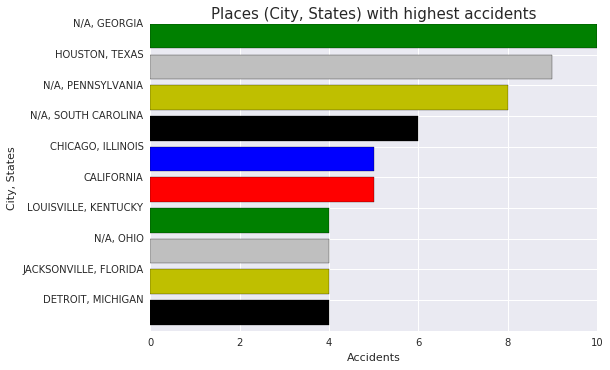

In [12]:
place = accidents_df.groupBy('Place').count().sort('count', ascending=False).toPandas()
colors = ['g','0.75','y','k','b','r']
place = place.ix[:9]
plt.barh(range(10),place['count'], color=colors)
plt.xlabel('Accidents')
plt.ylabel('City, States')
plt.title('Places (City, States) with highest accidents', size=15)
plt.yticks(range(10), place['Place'])
plt.gca().invert_yaxis()
plt.show()